In [2]:
#Jupyter notebook to check if imports work correctly
%matplotlib inline
import sys
sys.path.append('./src')
import HubbardEvolutionChain as hc
import ClassicalHubbardEvolutionChain as chc
from qiskit import QuantumCircuit, execute, Aer, IBMQ, BasicAer, QuantumRegister, ClassicalRegister
from qiskit.compiler import transpile, assemble
from qiskit.quantum_info import Operator
from qiskit.tools.monitor import job_monitor
from qiskit.tools.jupyter import *
import qiskit.visualization as qvis
import random as rand
import scipy.linalg as la

provider = IBMQ.load_account()

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from matplotlib import rcParams
rcParams['text.usetex'] = True


def get_bin(x, n=0):
    """
    Get the binary representation of x.
    Parameters: x (int), n (int, number of digits)"""
    binry = format(x, 'b').zfill(n)
    sup = list( reversed( binry[0:int(len(binry)/2)] ) )
    sdn = list( reversed( binry[int(len(binry)/2):len(binry)] ) )
    return format(x, 'b').zfill(n)

ibmqfactory.load_account:WARNING:2021-04-11 15:41:48,433: Credentials are already in use. The existing account in the session will be replaced.


In [53]:
#Energy Measurement Functions

#Measure the total repulsion from circuit run
def measure_repulsion(U, num_sites, results, shots):
    repulsion = 0.
    #Figure out how to include different hoppings later
    for state in results:
        for i in range( int( len(state)/2 ) ):
            if state[i]=='1':
                if state[i+num_sites]=='1':
                    repulsion += U*results.get(state)/shots
    
    return repulsion
                    
        

def measure_hopping(hopping, pairs, circuit, num_qubits):
    #Add diagonalizing circuit
    for pair in pairs:
        circuit.cnot(pair[0],pair[1])
        circuit.ch(pair[1],pair[0])
        circuit.cnot(pair[0],pair[1])
        #circuit.measure(pair[0],pair[0])
        #circuit.measure(pair[1],pair[1])
    circuit.measure_all()
    #Run circuit
    backend = Aer.get_backend('qasm_simulator')
    shots = 8192
    max_credits = 10 #Max number of credits to spend on execution
    #print("Computing Hopping")
    hop_exp = execute(circuit, backend=backend, shots=shots, max_credits=max_credits)
    job_monitor(hop_exp)
    result = hop_exp.result()
    counts = result.get_counts(circuit)
    #print(counts)
    #Compute energy
    #print(pairs)
    for pair in pairs:
        hop_eng = 0.
        #print('Pair is: ',pair)
        for state in counts:
            #print('State is: ',state,'   Index at pair[0]: ',num_qubits-1-pair[0],'    Val: ',state[num_qubits-pair[0]])
            if state[num_qubits-1-pair[0]]=='1':
                prob_01 = counts.get(state)/shots
                #print('Check state is: ',state)
                for comp_state in counts:
                    #print('Comp State is: ',state,'   Index at pair[0]: ',num_qubits-1-pair[1],'    Val: ',comp_state[num_qubits-pair[0]])
                    if comp_state[num_qubits-1-pair[1]]=='1':
                        #print('Comp state is: ',comp_state)
                        hop_eng += -hopping*(prob_01 - counts.get(comp_state)/shots)
    return hop_eng


In [69]:

#nsites, excitations, total_time, dt, hop, U, trotter_steps
dt = 0.25 #Delta t
total_time = 5.
#time_steps = int(T/dt)
hop = 1.0  #Hopping parameter
#t = [1.0, 2.]
U = 2.  #On-Site repulsion
#time_steps = 10
nsites = 3
trotter_steps = 1000
excitations = np.array([1])



numq = 2*nsites
num_steps = int(total_time/dt)
print('Num Steps: ',num_steps)
print('Total Time: ', total_time)
data = np.zeros((2**numq, num_steps))
energies = np.zeros(num_steps)

for t_step in range(0, num_steps):
    #Create circuit with t_step number of steps
    q = QuantumRegister(numq)
    c = ClassicalRegister(numq)
    qcirc = QuantumCircuit(q,c)

    #=========USE THIS REGION TO SET YOUR INITIAL STATE==============
      #Loop over each excitation 
    for flip in excitations:
        qcirc.x(flip)
    #===============================================================

    qcirc.barrier()
    #Append circuit with Trotter steps needed
    hc.qc_evolve(qcirc, nsites, t_step*dt, hop, U, trotter_steps)
    #Measure the circuit
    for i in range(numq):
        qcirc.measure(i, i)

#Choose provider and backend
    provider = IBMQ.get_provider()
    #backend = Aer.get_backend('statevector_simulator')
    backend = Aer.get_backend('qasm_simulator')
    #backend = provider.get_backend('ibmq_qasm_simulator')
    #backend = provider.get_backend('ibmqx4')
    #backend = provider.get_backend('ibmqx2')
    #backend = provider.get_backend('ibmq_16_melbourne')
    shots = 8192
    max_credits = 10 #Max number of credits to spend on execution
    job_exp = execute(qcirc, backend=backend, shots=shots, max_credits=max_credits)
    #job_monitor(job_exp)
    result = job_exp.result()
    counts = result.get_counts(qcirc)
    print(result.get_counts(qcirc))
    print("Job: ",t_step+1, " of ", num_steps," computing energy...")

#Store results in data array and normalize them
    for i in range(2**numq):
        if counts.get(get_bin(i,numq)) is None:
            dat = 0
        else:
            dat = counts.get(get_bin(i,numq))
        data[i,t_step] = dat/shots

#=======================================================
    #Compute energy of system
    #Compute repulsion energies
    repulsion_energy = measure_repulsion(U, nsites, counts, shots)
    print('Repulsion: ', repulsion_energy)
    #Compute hopping energies
    #Get list of hopping pairs
    even_pairs = []
    for i in range(0,nsites-1,2):
        #up_pair = [i, i+1]
        #dwn_pair = [i+nsites, i+nsites+1]
        even_pairs.append([i, i+1])
        even_pairs.append([i+nsites, i+nsites+1])
    odd_pairs = []
    for i in range(1,nsites-1,2):
        odd_pairs.append([i, i+1])
        odd_pairs.append([i+nsites, i+nsites+1])

    #Start with even hoppings, initialize circuit and find hopping pairs
    q = QuantumRegister(numq)
    c = ClassicalRegister(numq)
    qcirc = QuantumCircuit(q,c)
      #Loop over each excitation 
    for flip in excitations:
        qcirc.x(flip)
    qcirc.barrier()
    #Append circuit with Trotter steps needed
    hc.qc_evolve(qcirc, nsites, t_step*dt, hop, U, trotter_steps)
    '''for pair in odd_pairs:
        qcirc.cnot(pair[0],pair[1])
        qcirc.ch(pair[1],pair[0])
        qcirc.cnot(pair[0],pair[1])
        qcirc.measure(pair[0],pair[0])
        qcirc.measure(pair[1],pair[1])
    #circuit.draw()
    print(t_step)
    '''
    #break
    even_hopping = measure_hopping(hop, even_pairs, qcirc, numq)
    print('Even hopping: ', even_hopping)
    #===============================================================
    #Now do the same for the odd hoppings
    #Start with even hoppings, initialize circuit and find hopping pairs
    q = QuantumRegister(numq)
    c = ClassicalRegister(numq)
    qcirc = QuantumCircuit(q,c)
      #Loop over each excitation 
    for flip in excitations:
        qcirc.x(flip)
    qcirc.barrier()
    #Append circuit with Trotter steps needed
    hc.qc_evolve(qcirc, nsites, t_step*dt, hop, U, trotter_steps)
    odd_hopping = measure_hopping(hop, odd_pairs, qcirc, numq)
    print('Odd hopping: ',odd_hopping)
    total_energy = repulsion_energy + even_hopping + odd_hopping
    print(total_energy)
    energies[t_step] = total_energy
    print("Total Energy is: ", total_energy)
    print("Job: ",t_step+1, " of ", num_steps," complete")
    
#qcirc.draw()

Num Steps:  20
Total Time:  5.0
{'000010': 8192}
Job:  1  of  20  computing energy...
Repulsion:  0.0
Job Status: job has successfully run
Even hopping:  0.0
Job Status: job has successfully run
Odd hopping:  0.0
0.0
Total Energy is:  0.0
Job:  1  of  20  complete
{'000001': 437, '000010': 7238, '000100': 517}
Job:  2  of  20  computing energy...
Repulsion:  0.0
Job Status: job has successfully run
Even hopping:  0.0
Job Status: job has successfully run
Odd hopping:  0.0
0.0
Total Energy is:  0.0
Job:  2  of  20  complete
{'000001': 1765, '000010': 4696, '000100': 1731}
Job:  3  of  20  computing energy...
Repulsion:  0.0
Job Status: job has successfully run
Even hopping:  0.0
Job Status: job has successfully run
Odd hopping:  0.0
0.0
Total Energy is:  0.0
Job:  3  of  20  complete
{'000001': 3036, '000010': 1996, '000100': 3160}
Job:  4  of  20  computing energy...
Repulsion:  0.0
Job Status: job has successfully run
Even hopping:  0.0
Job Status: job has successfully run
Odd hopping:

0.5821533203125


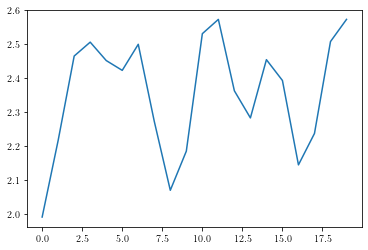

In [68]:
plt.plot(energies)
print(np.ptp(energies))
#Trotter Steps=1000

0.7239990234375


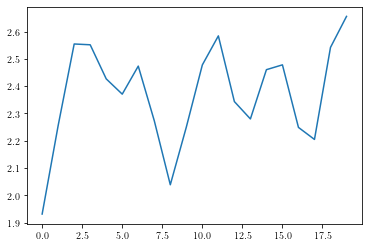

In [64]:
plt.plot(energies)
print(np.ptp(energies))
#Trotter Steps=100

0.7039794921875


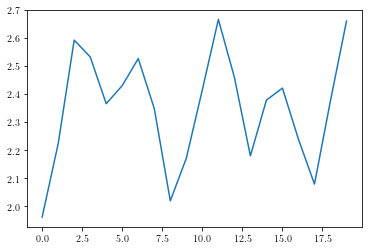

In [62]:
plt.plot(energies)
print(np.ptp(energies))
#Trotter Steps=50

1.408447265625


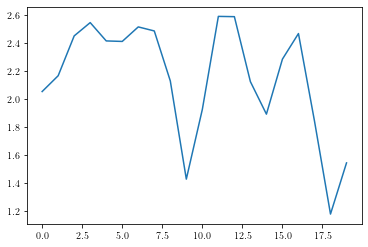

In [66]:
plt.plot(energies)
print(np.ptp(energies))
#Trotter Steps=10

0.0


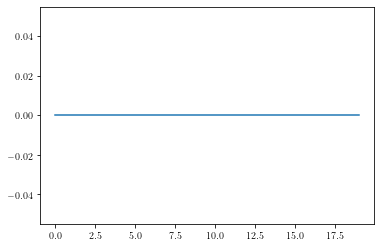

In [70]:
plt.plot(energies)
print(np.ptp(energies))
#Trotter Steps=100